In [1]:
import os
import itertools
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
from util.scrape_log import scrape_search_log
from dataset.goose_domain_info import GOOSE_DOMAINS

In [2]:
DOMAINS = sorted(GOOSE_DOMAINS)
CONFIGS = list(itertools.product(["llg", "slg"], ["wl"], [1, 3, 5]))
CONFIGS

[('llg', 'wl', 1),
 ('llg', 'wl', 3),
 ('llg', 'wl', 5),
 ('slg', 'wl', 1),
 ('slg', 'wl', 3),
 ('slg', 'wl', 5)]

In [3]:
f = "logs_kernel/test/blocks_blocks15-task01_trained_models_kernel-llg_blocks_wl_1.joblib.log"
stats = scrape_search_log(f)
stats

{'first_h': -1,
 'solved': 0,
 'time': -1,
 'cost': -1,
 'expanded': -1,
 'evaluated': -1}

### DataFrame

In [4]:
d = {
'config': [],
'domain': [],
}
for key in stats:
  d[key] = []

for rep, kernel, iterations in CONFIGS:
  for domain in DOMAINS:
    m = f"trained_models_kernel-{rep}_{domain}_{kernel}_{iterations}.joblib"

    problem_dir = f"../benchmarks/goose/{domain}/test"
    for p in os.listdir(problem_dir):
      problem_name = os.path.basename(p).replace(".pddl", "")
      f = f"logs_kernel/test/{domain}_{problem_name}_{m}.log"
      stats = scrape_search_log(f)
      if stats['first_h'] != -1 and len(stats)+2 == len(d):
        d['config'].append('-'.join([rep, kernel, str(iterations)]))
        d['domain'].append(domain)
        for key in stats:
          d[key].append(stats[key])
df = pd.DataFrame(d)
df

,config,domain,first_h,solved,time,cost,expanded,evaluated


### Coverage

In [5]:
coverage = {'domain': []}
for rep, kernel, iterations in CONFIGS:
  coverage['-'.join([rep, kernel, str(iterations)])] = []

for domain in DOMAINS:
  coverage['domain'].append(domain)
  for rep, kernel, iterations in CONFIGS:
    solved = 0
    m = f"trained_models_kernel-{rep}_{domain}_{kernel}_{iterations}.joblib"

    problem_dir = f"../benchmarks/goose/{domain}/test"
    for p in os.listdir(problem_dir):
      problem_name = os.path.basename(p).replace(".pddl", "")
      f = f"logs_kernel/test/{domain}_{problem_name}_{m}.log"
      stats = scrape_search_log(f)
      solved += stats['solved']

    coverage['-'.join([rep, kernel, str(iterations)])].append(solved)
df_coverage=pd.DataFrame(coverage)
df_coverage

,domain,llg-wl-1,llg-wl-3,llg-wl-5,slg-wl-1,slg-wl-3,slg-wl-5
0,blocks,0,0,0,0,0,0
1,ferry,0,0,0,0,0,0
2,gripper,0,0,0,0,0,0
3,n-puzzle,0,0,0,0,0,0
4,sokoban,0,0,0,0,0,0
5,spanner,0,0,0,0,0,0
6,visitall,0,0,0,0,0,0
7,visitsome,0,0,0,0,0,0


### Time per expansion and evaluation

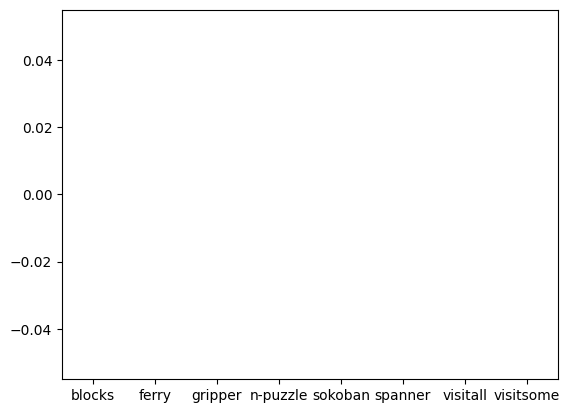

In [6]:
rep="llg"
kernel="wl"
iterations=1

times = {}

for domain in DOMAINS:
  times[domain] = []

  solved = 0
  m = f"trained_models_kernel-{rep}_{domain}_{kernel}_{iterations}.joblib"

  problem_dir = f"../benchmarks/goose/{domain}/test"
  for p in os.listdir(problem_dir):
    problem_name = os.path.basename(p).replace(".pddl", "")

    f = f"logs_kernel/test/{domain}_{problem_name}_{m}.log"
    stats = scrape_search_log(f)
    if not stats['solved']:
      continue

    times[domain].append(stats['time']/stats['evaluated'])
  
fig, ax = plt.subplots()
ax.boxplot(times.values())
ax.set_xticklabels(times.keys())
plt.show()

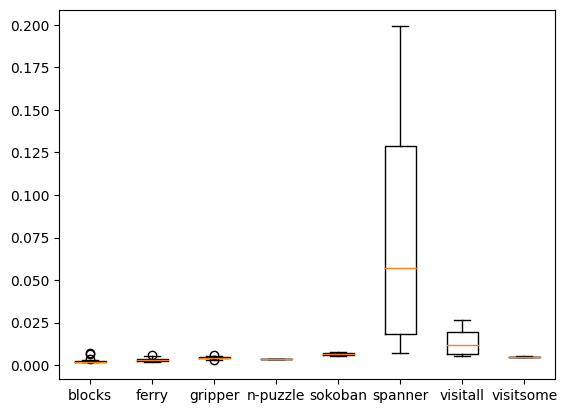

In [7]:
times = {}

for domain in DOMAINS:
  times[domain] = []

  solved = 0
  m = f"trained_models_kernel-{rep}_{domain}_{kernel}_{iterations}.joblib"

  problem_dir = f"../benchmarks/goose/{domain}/test"
  for p in os.listdir(problem_dir):
    problem_name = os.path.basename(p).replace(".pddl", "")

    f = f"logs/test/{problem_name}_dd_ldg-el_{domain}_L4_H64_max_p10_r0.log"
    stats = scrape_search_log(f)
    if not stats['solved']:
      continue

    times[domain].append(stats['time']/stats['evaluated'])
  
fig, ax = plt.subplots()
ax.boxplot(times.values())
ax.set_xticklabels(times.keys())
plt.show()

### Kernel vs. GNN

In [8]:
rep="llg"
kernel="wl"
iterations=1

def scatter(metric, MAX_VAL, log):
  for domain in DOMAINS:
    xs = []
    ys = []

    solved = 0
    m = f"trained_models_kernel-{rep}_{domain}_{kernel}_{iterations}.joblib"

    problem_dir = f"../benchmarks/goose/{domain}/test"
    for p in os.listdir(problem_dir):
      problem_name = os.path.basename(p).replace(".pddl", "")

      f = f"logs_kernel/test/{domain}_{problem_name}_{m}.log"
      stats = scrape_search_log(f)
      if not stats['solved']:
        x = MAX_VAL
      else:
        x = stats[metric]
      
      f = f"logs/test/{problem_name}_dd_ldg-el_{domain}_L4_H64_max_p10_r0.log"
      stats = scrape_search_log(f)
      if not stats['solved']:
        y = MAX_VAL
      else:
        y = stats[metric]

      xs.append(x)
      ys.append(y)
    
    plt.scatter(xs, ys, alpha=0.8, marker='x', label=domain)
  plt.xlim(left=1, right=MAX_VAL)
  plt.ylim(bottom=1, top=MAX_VAL)
  if log:
    plt.xscale("log")
    plt.yscale("log")
  plt.title(metric)
  plt.xlabel("kernel")
  plt.ylabel("GNN")
  plt.plot([1,MAX_VAL], [1,MAX_VAL], alpha=0.5, c='k', linestyle="dashed")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

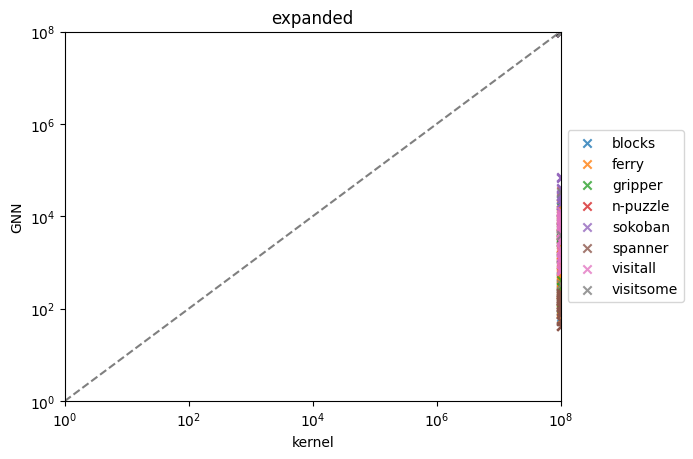

In [9]:
metric="expanded"
MAX_VAL = 1e8
log = True
scatter(metric, MAX_VAL, log)

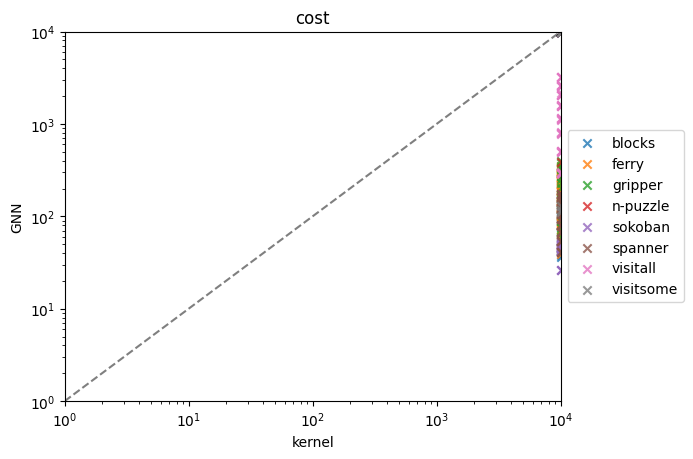

In [10]:
metric="cost"
MAX_VAL = 1e4
log = True
scatter(metric, MAX_VAL, log)

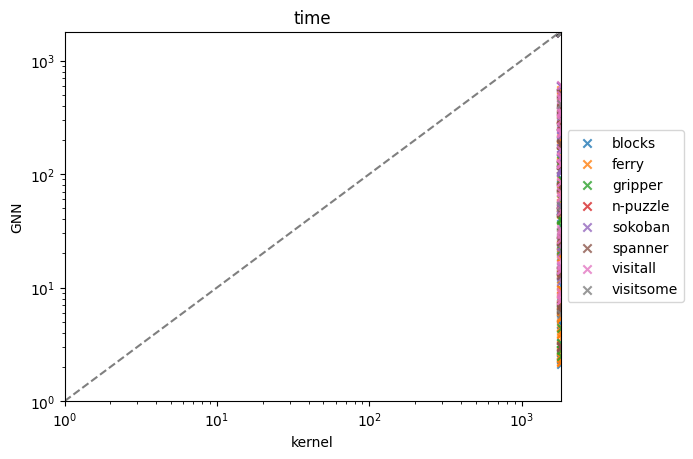

In [11]:
metric="time"
MAX_VAL = 1800
log = True
scatter(metric, MAX_VAL, log)